In [178]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/analytics-vidhya-ltfs-data-science-finhack-3/sample_submission_ejm25Dc.csv
/kaggle/input/analytics-vidhya-ltfs-data-science-finhack-3/Data/Data/sample_submission_ejm25Dc.csv
/kaggle/input/analytics-vidhya-ltfs-data-science-finhack-3/Data/Data/train_bureau.csv
/kaggle/input/analytics-vidhya-ltfs-data-science-finhack-3/Data/Data/data_dict.csv
/kaggle/input/analytics-vidhya-ltfs-data-science-finhack-3/Data/Data/train_Data.csv
/kaggle/input/analytics-vidhya-ltfs-data-science-finhack-3/Data/Data/test_Data.csv
/kaggle/input/analytics-vidhya-ltfs-data-science-finhack-3/Data/Data/test_bureau.csv
/kaggle/input/analytics-vidhya-ltfs-data-science-finhack-3/Test/test_bureau.xlsx
/kaggle/input/analytics-vidhya-ltfs-data-science-finhack-3/Test/test_Data.xlsx
/kaggle/input/analytics-vidhya-ltfs-data-science-finhack-3/Train/Train/train_bureau.xlsx
/kaggle/input/analytics-vidhya-ltfs-data-science-finhack-3/Train/Train/data_dict.xlsx
/kaggle/input/analytics-vidhya-ltfs-data-science-finhack

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,train_test_split,KFold,StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

In [180]:
train = pd.read_csv("/kaggle/input/analytics-vidhya-ltfs-data-science-finhack-3/Data/Data/train_Data.csv",parse_dates=['DisbursalDate','MaturityDAte','AuthDate'])

test = pd.read_csv("/kaggle/input/analytics-vidhya-ltfs-data-science-finhack-3/Data/Data/test_Data.csv",parse_dates=['DisbursalDate','MaturityDAte','AuthDate'])


types = {"ID":"int32","WRITE-OFF-AMT":"float32","TENURE":"float16"}
test_bureau = pd.read_csv(r"../input/analytics-vidhya-ltfs-data-science-finhack-3/Data/Data/test_bureau.csv",dtype=types,parse_dates=['DATE-REPORTED','DISBURSED-DT','CLOSE-DT','LAST-PAYMENT-DATE'])

types = {"ID":"int32","WRITE-OFF-AMT":"float32","TENURE":"float16"}
train_bureau = pd.read_csv(r"../input/analytics-vidhya-ltfs-data-science-finhack-3/Data/Data/train_bureau.csv",dtype=types,parse_dates=['DATE-REPORTED','DISBURSED-DT','CLOSE-DT','LAST-PAYMENT-DATE'])

In [181]:
Submission = test[['ID']]

# Combining the train and test datasets for better EDA
train['Source'] = "Train"
test['Source'] = "Test"

df = pd.concat([train,test],axis=0)
df.shape

(143400, 27)

# EDA - Bureau Data

In [182]:
# Dropping duplicates, if any
train_bureau = train_bureau.drop_duplicates()
test_bureau = test_bureau.drop_duplicates()

In [183]:
train_bureau.shape,test_bureau.shape

((556980, 25), (63331, 25))

In [184]:
train_bureau['Source'] = "Train"
test_bureau['Source'] = "Test"
bureau_data = pd.concat([train_bureau,test_bureau],axis=0)
bureau_data.shape

(620311, 26)

In [185]:
bureau_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 620311 entries, 0 to 64018
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   ID                         620311 non-null  int32         
 1   SELF-INDICATOR             620311 non-null  bool          
 2   MATCH-TYPE                 620311 non-null  object        
 3   ACCT-TYPE                  620311 non-null  object        
 4   CONTRIBUTOR-TYPE           620311 non-null  object        
 5   DATE-REPORTED              616634 non-null  datetime64[ns]
 6   OWNERSHIP-IND              620311 non-null  object        
 7   ACCOUNT-STATUS             620311 non-null  object        
 8   DISBURSED-DT               588384 non-null  datetime64[ns]
 9   CLOSE-DT                   340799 non-null  object        
 10  LAST-PAYMENT-DATE          269683 non-null  datetime64[ns]
 11  CREDIT-LIMIT/SANC AMT      16688 non-null   object   

1. We can see there are 18 variables that are of object dtype and few are of datetime dtype followed by 1 each in float and int category. 
2. We can also see that there are many variables with missing values. If the percentage of missing values is more than 50%, we will go ahead and delete the variable. 
3. We also have to check the object variables, about the cardinality. If there are many values, we might have to combine a few of them. 

In [186]:
(bureau_data.isna().sum()/len(bureau_data))*100

ID                            0.000000
SELF-INDICATOR                0.000000
MATCH-TYPE                    0.000000
ACCT-TYPE                     0.000000
CONTRIBUTOR-TYPE              0.000000
DATE-REPORTED                 0.592767
OWNERSHIP-IND                 0.000000
ACCOUNT-STATUS                0.000000
DISBURSED-DT                  5.146934
CLOSE-DT                     45.059978
LAST-PAYMENT-DATE            56.524550
CREDIT-LIMIT/SANC AMT        97.309737
DISBURSED-AMT/HIGH CREDIT     0.006126
INSTALLMENT-AMT              75.177613
CURRENT-BAL                   0.042559
INSTALLMENT-FREQUENCY        76.010098
OVERDUE-AMT                  21.128756
WRITE-OFF-AMT                 3.485832
ASSET_CLASS                  53.883294
REPORTED DATE - HIST          3.485832
DPD - HIST                    3.559666
CUR BAL - HIST                3.485832
AMT OVERDUE - HIST            3.485832
AMT PAID - HIST               3.691697
TENURE                       65.981097
Source                   

In [187]:
bureau_data.head()

,ID,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,LAST-PAYMENT-DATE,CREDIT-LIMIT/SANC AMT,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE,Source
0,1,False,PRIMARY,Overdraft,NAB,2018-04-30,Individual,Delinquent,2015-10-05,NaN,2018-02-27,NaN,"37,352",NaN,"37,873",NaN,"37,873",0.0,Standard,"20180430,20180331,",030000,"37873,12820,","37873,,",",,",NaN,Train
1,1,False,PRIMARY,Auto Loan (Personal),NAB,2019-12-31,Individual,Active,2018-03-19,NaN,2019-12-19,NaN,"44,000","1,405/Monthly","20,797",F03,NaN,0.0,Standard,"20191231,20191130,20191031,20190930,20190831,2...",0000000000000000000000000000000000000000000000...,"20797,21988,23174,24341,25504,26648,27780,2891...",",,,,,,,,,,,,,,,,,,,,1452,,",",,,,,,,,,,,,,,,,,,,,,,",36.0,Train
2,1,True,PRIMARY,Tractor Loan,NBF,2020-01-31,Individual,Active,2019-08-30,NaN,NaT,NaN,"1,45,000",NaN,"1,16,087",NaN,0,0.0,NaN,"20200131,20191231,20191130,20191031,20190930,2...",000000000000000000,"116087,116087,145000,145000,145000,145000,","0,0,0,0,0,0,",",,,,,,",NaN,Train
3,1,True,PRIMARY,Auto Loan (Personal),NBF,2017-09-30,Individual,Closed,2013-09-27,2017-09-21 00:00:00,NaT,NaN,"3,00,000",NaN,0,NaN,0,0.0,NaN,"20170930,20170801,20170731,20170630,20170531,2...",000DDD0270260270260270240270270000320000000000...,"0,,15925,23754,31494,39147,46713,54194,61590,6...","0,,1014,1014,1014,1014,1014,1014,1014,983,0,92...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN,Train
4,1,True,PRIMARY,Tractor Loan,NBF,2016-02-29,Individual,Closed,2012-02-10,2016-02-01 00:00:00,NaT,NaN,"2,75,000",NaN,0,NaN,0,0.0,NaN,"20160229,20160131,20151231,20151130,20151031,2...",0000000000000000000000000000000000000000000000...,"0,0,23658,23321,22989,46321,45662,45012,68030,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN,Train


In [188]:
for col in bureau_data.columns:
    if bureau_data[col].dtype == "object":
        print ("Value Count of {} column are:\n{}".format(col,bureau_data[col].value_counts(dropna=False)))

Value Count of MATCH-TYPE column are:
PRIMARY      620086
SECONDARY       225
Name: MATCH-TYPE, dtype: int64
Value Count of ACCT-TYPE column are:
Tractor Loan                                                           207869
Gold Loan                                                               98370
Business Loan Priority Sector  Agriculture                              88083
Kisan Credit Card                                                       37588
Auto Loan (Personal)                                                    33432
Other                                                                   29602
Commercial Vehicle Loan                                                 20484
Two-Wheeler Loan                                                        17641
Credit Card                                                             14081
Consumer Loan                                                           13675
Overdraft                                                               10

Value Count of CUR BAL - HIST column are:
,                                                                                                                                                                                                                                              34732
NaN                                                                                                                                                                                                                                            21623
0,                                                                                                                                                                                                                                              9709
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,                                                                                                                                                       

In [189]:
# We will drop the MATCH-TYPE column as it has one value which is dominating
bureau_data.drop("MATCH-TYPE",axis=1,inplace=True)

# We will combine the values of certain columns which are few in number
bureau_data['ACCT-TYPE'].replace({"Secured Credit Card":"Others",
                                  "Business Non-Funded Credit Facility General":"Others",
                                  "Prime Minister Jaan Dhan Yojana - Overdraft":"Others",
                                  "Pradhan Mantri Awas Yojana - CLSS":"Others",
                                  "SHG Individual":"Others",
                                  "JLG Group":"Others",
                                  "Microfinance Personal Loan":"Others",
                                  "Fleet Card":"Others",
                                  "Microfinance Housing Loan":"Others",
                                  "Commercial Equipment Loan":"Others",
                                  "Corporate Credit Card":"Others",
                                  "Loan on Credit Card":"Others",
                                  "Business Non-Funded Credit Facility-Priority Sector-Others":"Others",
                                  "Leasing":"Others",
                                  "Telco Landline":"Others",
                                  "SHG Group":"Others",
                                  "Staff Loan":"Others"},inplace=True)
bureau_data['CONTRIBUTOR-TYPE'].replace({"SFB":"Others",
                                         "ARC":"Others",
                                         "OFI":"Others"},inplace=True)
bureau_data['ACCOUNT-STATUS'].replace({"SUIT FILED (WILFUL DEFAULT)":"Others",
                                       "WILFUL DEFAULT":"Others",
                                       "Sold/Purchased":"Others",
                                       "Cancelled":"Others"},inplace=True)

# We will drop the ASSET_CLASS variable as it has majority of missing values.
bureau_data.drop("ASSET_CLASS",axis=1,inplace=True)

In [190]:
bureau_data.isna().sum()/len(bureau_data)

ID                           0.000000
SELF-INDICATOR               0.000000
ACCT-TYPE                    0.000000
CONTRIBUTOR-TYPE             0.000000
DATE-REPORTED                0.005928
OWNERSHIP-IND                0.000000
ACCOUNT-STATUS               0.000000
DISBURSED-DT                 0.051469
CLOSE-DT                     0.450600
LAST-PAYMENT-DATE            0.565245
CREDIT-LIMIT/SANC AMT        0.973097
DISBURSED-AMT/HIGH CREDIT    0.000061
INSTALLMENT-AMT              0.751776
CURRENT-BAL                  0.000426
INSTALLMENT-FREQUENCY        0.760101
OVERDUE-AMT                  0.211288
WRITE-OFF-AMT                0.034858
REPORTED DATE - HIST         0.034858
DPD - HIST                   0.035597
CUR BAL - HIST               0.034858
AMT OVERDUE - HIST           0.034858
AMT PAID - HIST              0.036917
TENURE                       0.659811
Source                       0.000000
dtype: float64

We can see a lot of missing values in TENURE, OVERDUE-AMT, INSTALLMENT-FREQUENCY, INSTALLMENT-AMT, CREDIT-LIMIT/SANC AMT, LAST-PAYMENT-DATE and CLOSE-DT variables. We can delete these variables.

In [191]:
bureau_data.drop(['TENURE','OVERDUE-AMT','INSTALLMENT-FREQUENCY','CREDIT-LIMIT/SANC AMT','LAST-PAYMENT-DATE','CLOSE-DT'],axis=1,inplace=True)

In [192]:
# We will delete the Date Variables as of now
bureau_data.drop(['DATE-REPORTED','DISBURSED-DT','REPORTED DATE - HIST'],axis=1,inplace=True)

In [193]:
bureau_data.head()

,ID,SELF-INDICATOR,ACCT-TYPE,CONTRIBUTOR-TYPE,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,WRITE-OFF-AMT,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,Source
0,1,False,Overdraft,NAB,Individual,Delinquent,"37,352",NaN,"37,873",0.0,030000,"37873,12820,","37873,,",",,",Train
1,1,False,Auto Loan (Personal),NAB,Individual,Active,"44,000","1,405/Monthly","20,797",0.0,0000000000000000000000000000000000000000000000...,"20797,21988,23174,24341,25504,26648,27780,2891...",",,,,,,,,,,,,,,,,,,,,1452,,",",,,,,,,,,,,,,,,,,,,,,,",Train
2,1,True,Tractor Loan,NBF,Individual,Active,"1,45,000",NaN,"1,16,087",0.0,000000000000000000,"116087,116087,145000,145000,145000,145000,","0,0,0,0,0,0,",",,,,,,",Train
3,1,True,Auto Loan (Personal),NBF,Individual,Closed,"3,00,000",NaN,0,0.0,000DDD0270260270260270240270270000320000000000...,"0,,15925,23754,31494,39147,46713,54194,61590,6...","0,,1014,1014,1014,1014,1014,1014,1014,983,0,92...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",Train
4,1,True,Tractor Loan,NBF,Individual,Closed,"2,75,000",NaN,0,0.0,0000000000000000000000000000000000000000000000...,"0,0,23658,23321,22989,46321,45662,45012,68030,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",Train


In [194]:
bureau_data.drop(bureau_data[bureau_data['WRITE-OFF-AMT']<0].index,axis=0,inplace=True)

In [195]:
bureau_data[bureau_data['WRITE-OFF-AMT']<0]

,ID,SELF-INDICATOR,ACCT-TYPE,CONTRIBUTOR-TYPE,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,WRITE-OFF-AMT,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,Source


In [196]:
# Some of the numerical variables are coded as of object type because of the comma in the numbers, we convert them to the right data type.
bureau_data['DISBURSED-AMT/HIGH CREDIT'] = bureau_data['DISBURSED-AMT/HIGH CREDIT'].str.replace(",","")
bureau_data['DISBURSED-AMT/HIGH CREDIT'] = pd.to_numeric(bureau_data['DISBURSED-AMT/HIGH CREDIT'])

bureau_data['CURRENT-BAL'] = bureau_data['CURRENT-BAL'].str.replace(",","")
bureau_data['CURRENT-BAL'] = pd.to_numeric(bureau_data['CURRENT-BAL'])

In [197]:
bureau_data['DISBURSED-AMT/HIGH CREDIT'].fillna(bureau_data['DISBURSED-AMT/HIGH CREDIT'].mean(),inplace=True)
bureau_data['CURRENT-BAL'].fillna(bureau_data['CURRENT-BAL'].mean(),inplace=True)
bureau_data['WRITE-OFF-AMT'].fillna(bureau_data['WRITE-OFF-AMT'].mean(),inplace=True)

In [198]:
bureau_data.isna().sum()

ID                                0
SELF-INDICATOR                    0
ACCT-TYPE                         0
CONTRIBUTOR-TYPE                  0
OWNERSHIP-IND                     0
ACCOUNT-STATUS                    0
DISBURSED-AMT/HIGH CREDIT         0
INSTALLMENT-AMT              466333
CURRENT-BAL                       0
WRITE-OFF-AMT                     0
DPD - HIST                    22081
CUR BAL - HIST                21623
AMT OVERDUE - HIST            21623
AMT PAID - HIST               22900
Source                            0
dtype: int64

In [199]:
train_bureau = bureau_data[bureau_data['Source']=="Train"]
test_bureau = bureau_data[bureau_data['Source']=="Test"]

train_bureau.drop("Source",axis=1,inplace=True)
test_bureau.drop("Source",axis=1,inplace=True)

In [200]:
def ddp_hist_func(value):
    history =  [value[i:i+3] for i in range(0,len(value),3)]
    count_no_delays = len([c for c in history if c=="000"])
    count_no_payment_history_this_month = len([c for c in history if c=="DDD"])
    count_no_payment_history_prior = len([c for c in history if c=="XXX"])
    count_payments_past_due_date = len(history)-count_no_delays-count_no_payment_history_this_month-count_no_payment_history_prior
    return count_no_delays,count_payments_past_due_date,count_no_payment_history_this_month,count_no_payment_history_prior

train_bureau['DPD - HIST'].fillna(",",inplace=True)
train_bureau['DPD_History_Months'] = train_bureau['DPD - HIST'].apply(ddp_hist_func)

ddp_hist =pd.DataFrame(train_bureau['DPD_History_Months'].tolist())
ddp_hist.columns = ['Count_No_Delays_In_Payment','Count_Payment_Past_Due_Date','History_Not_Available_Curr_Month','History_Not_Available_Prior_Month']
train_bureau = pd.concat([train_bureau,ddp_hist],axis=1)
train_bureau.drop('DPD_History_Months',axis=1,inplace=True)


def cur_bal_func(val):
    history = val.split(",")[:-1]
    history_lst = [int(item) if item!="" else 0 for item in history]
    
    max_cur_bal = max(np.array(history_lst))
    min_cur_bal = min(np.array(history_lst))
    sum_cur_bal = sum(np.array(history_lst))
    avg_cur_bal = np.mean(np.array(history_lst))
    
    sum_successive_diff = np.sum(np.diff(np.array(history_lst)))
    avg_successive_diff = sum_successive_diff/len(np.diff(np.array(history_lst)))
    
    return min_cur_bal,max_cur_bal,sum_cur_bal,avg_cur_bal,sum_successive_diff,avg_successive_diff

train_bureau['CUR BAL - HIST'].fillna(",",inplace=True)
train_bureau['CUR_Bal_History_Months'] = train_bureau['CUR BAL - HIST'].apply(cur_bal_func)

cur_bal_hist =pd.DataFrame(train_bureau['CUR_Bal_History_Months'].tolist())
cur_bal_hist.columns = ['Min_Cur_Bal','Max_Cur_Bal','Sum_Cur_Bal','Avg_Cur_Bal','Sum_Successive_Diff_CurBal','Avg_Successive_Diff_CurBal']
train_bureau = pd.concat([train_bureau,cur_bal_hist],axis=1)
train_bureau.drop('CUR_Bal_History_Months',axis=1,inplace=True)


def amt_overdue_func(val):
    history = val.split(",")
    history_lst = [int(item) if item!="" else 0 for item in history]
    
    max_overdue = max(np.array(history_lst))
    min_overdue = min(np.array(history_lst))
    sum_overdue = sum(np.array(history_lst))
    avg_overdue = np.mean(np.array(history_lst))
    
    sum_successive_diff = np.sum(np.diff(np.array(history_lst)))
    avg_successive_diff = sum_successive_diff/len(np.diff(np.array(history_lst)))
        
    return min_overdue,max_overdue,sum_overdue,avg_overdue,sum_successive_diff,avg_successive_diff

train_bureau['AMT OVERDUE - HIST'].fillna(",",inplace=True)
train_bureau['AMT_Overdue_History_Months'] = train_bureau['AMT OVERDUE - HIST'].apply(amt_overdue_func)

amt_overdue_hist =pd.DataFrame(train_bureau['AMT_Overdue_History_Months'].tolist())
amt_overdue_hist.columns = ['Min_Overdue','Max_Overdue','Sum_Overdue','Avg_Overdue','Sum_Successive_Diff_Overdue','Avg_Successive_Diff_Overdue']
train_bureau = pd.concat([train_bureau,amt_overdue_hist],axis=1)
train_bureau.drop('AMT_Overdue_History_Months',axis=1,inplace=True)


def amt_paid_func(val):
    history = val.split(",")
    history_lst = [int(float(item)) if item!="" else 0 for item in history]
    
    max_amount_paid = max(np.array(history_lst))
    min_amount_paid = min(np.array(history_lst))
    sum_amount_paid = sum(np.array(history_lst))
    avg_amount_paid = np.mean(np.array(history_lst))
    
    return min_amount_paid,max_amount_paid,sum_amount_paid,avg_amount_paid

train_bureau['AMT PAID - HIST'].fillna(",",inplace=True)
train_bureau['AMT_Paid_History_Months'] = train_bureau['AMT PAID - HIST'].apply(amt_paid_func)

amt_paid_hist =pd.DataFrame(train_bureau['AMT_Paid_History_Months'].tolist())
amt_paid_hist.columns = ['Min_Amount_Paid','Max_Amount_Paid','Sum_Amount_Paid','Avg_Amount_Paid']
train_bureau = pd.concat([train_bureau,amt_paid_hist],axis=1)
train_bureau.drop('AMT_Paid_History_Months',axis=1,inplace=True)


def installment_amt_func(val):
    amount = val.split("/")[0]
    duration = val.split("/")[-1]
    return amount,duration

train_bureau['INSTALLMENT-AMT'].fillna("",inplace=True)
train_bureau['INSTALLMENT_HIST'] = train_bureau['INSTALLMENT-AMT'].apply(installment_amt_func)

installment_amt_hist =pd.DataFrame(train_bureau['INSTALLMENT_HIST'].tolist())
installment_amt_hist.columns = ['Installment_Amount','Installment_Frequency']
train_bureau = pd.concat([train_bureau,installment_amt_hist],axis=1)
train_bureau.drop(['INSTALLMENT_HIST','Installment_Frequency'],axis=1,inplace=True)


del installment_amt_hist,ddp_hist,amt_paid_hist,amt_overdue_hist,cur_bal_hist

In [201]:
train_bureau.drop(['AMT PAID - HIST','AMT OVERDUE - HIST','CUR BAL - HIST','DPD - HIST'],axis=1,inplace=True)

In [202]:
def ddp_hist_func(value):
    history =  [value[i:i+3] for i in range(0,len(value),3)]
    count_no_delays = len([c for c in history if c=="000"])
    count_no_payment_history_this_month = len([c for c in history if c=="DDD"])
    count_no_payment_history_prior = len([c for c in history if c=="XXX"])
    count_payments_past_due_date = len(history)-count_no_delays-count_no_payment_history_this_month-count_no_payment_history_prior
    return count_no_delays,count_payments_past_due_date,count_no_payment_history_this_month,count_no_payment_history_prior

test_bureau['DPD - HIST'].fillna(",",inplace=True)
test_bureau['DPD_History_Months'] = test_bureau['DPD - HIST'].apply(ddp_hist_func)

ddp_hist =pd.DataFrame(test_bureau['DPD_History_Months'].tolist())
ddp_hist.columns = ['Count_No_Delays_In_Payment','Count_Payment_Past_Due_Date','History_Not_Available_Curr_Month','History_Not_Available_Prior_Month']
test_bureau = pd.concat([test_bureau,ddp_hist],axis=1)
test_bureau.drop('DPD_History_Months',axis=1,inplace=True)


def cur_bal_func(val):
    history = val.split(",")[:-1]
    history_lst = [int(item) if item!="" else 0 for item in history]
    
    max_cur_bal = max(np.array(history_lst))
    min_cur_bal = min(np.array(history_lst))
    sum_cur_bal = sum(np.array(history_lst))
    avg_cur_bal = np.mean(np.array(history_lst))
    
    sum_successive_diff = np.sum(np.diff(np.array(history_lst)))
    avg_successive_diff = sum_successive_diff/len(np.diff(np.array(history_lst)))
    
    return min_cur_bal,max_cur_bal,sum_cur_bal,avg_cur_bal,sum_successive_diff,avg_successive_diff

test_bureau['CUR BAL - HIST'].fillna(",",inplace=True)
test_bureau['CUR_Bal_History_Months'] = test_bureau['CUR BAL - HIST'].apply(cur_bal_func)

cur_bal_hist =pd.DataFrame(test_bureau['CUR_Bal_History_Months'].tolist())
cur_bal_hist.columns = ['Min_Cur_Bal','Max_Cur_Bal','Sum_Cur_Bal','Avg_Cur_Bal','Sum_Successive_Diff_CurBal','Avg_Successive_Diff_CurBal']
test_bureau = pd.concat([test_bureau,cur_bal_hist],axis=1)
test_bureau.drop('CUR_Bal_History_Months',axis=1,inplace=True)


def amt_overdue_func(val):
    history = val.split(",")
    history_lst = [int(item) if item!="" else 0 for item in history]
    
    max_overdue = max(np.array(history_lst))
    min_overdue = min(np.array(history_lst))
    sum_overdue = sum(np.array(history_lst))
    avg_overdue = np.mean(np.array(history_lst))
    
    sum_successive_diff = np.sum(np.diff(np.array(history_lst)))
    avg_successive_diff = sum_successive_diff/len(np.diff(np.array(history_lst)))
        
    return min_overdue,max_overdue,sum_overdue,avg_overdue,sum_successive_diff,avg_successive_diff

test_bureau['AMT OVERDUE - HIST'].fillna(",",inplace=True)
test_bureau['AMT_Overdue_History_Months'] = test_bureau['AMT OVERDUE - HIST'].apply(amt_overdue_func)

amt_overdue_hist =pd.DataFrame(test_bureau['AMT_Overdue_History_Months'].tolist())
amt_overdue_hist.columns = ['Min_Overdue','Max_Overdue','Sum_Overdue','Avg_Overdue','Sum_Successive_Diff_Overdue','Avg_Successive_Diff_Overdue']
test_bureau = pd.concat([test_bureau,amt_overdue_hist],axis=1)
test_bureau.drop('AMT_Overdue_History_Months',axis=1,inplace=True)


def amt_paid_func(val):
    history = val.split(",")
    history_lst = [int(float(item)) if item!="" else 0 for item in history]
    
    max_amount_paid = max(np.array(history_lst))
    min_amount_paid = min(np.array(history_lst))
    sum_amount_paid = sum(np.array(history_lst))
    avg_amount_paid = np.mean(np.array(history_lst))
    
    return min_amount_paid,max_amount_paid,sum_amount_paid,avg_amount_paid

test_bureau['AMT PAID - HIST'].fillna(",",inplace=True)
test_bureau['AMT_Paid_History_Months'] = test_bureau['AMT PAID - HIST'].apply(amt_paid_func)

amt_paid_hist =pd.DataFrame(test_bureau['AMT_Paid_History_Months'].tolist())
amt_paid_hist.columns = ['Min_Amount_Paid','Max_Amount_Paid','Sum_Amount_Paid','Avg_Amount_Paid']
test_bureau = pd.concat([test_bureau,amt_paid_hist],axis=1)
test_bureau.drop('AMT_Paid_History_Months',axis=1,inplace=True)


def installment_amt_func(val):
    amount = val.split("/")[0]
    duration = val.split("/")[-1]
    return amount,duration

test_bureau['INSTALLMENT-AMT'].fillna("",inplace=True)
test_bureau['INSTALLMENT_HIST'] = test_bureau['INSTALLMENT-AMT'].apply(installment_amt_func)

installment_amt_hist =pd.DataFrame(test_bureau['INSTALLMENT_HIST'].tolist())
installment_amt_hist.columns = ['Installment_Amount','Installment_Frequency']
test_bureau = pd.concat([test_bureau,installment_amt_hist],axis=1)
test_bureau.drop(['INSTALLMENT_HIST','Installment_Frequency'],axis=1,inplace=True)


del installment_amt_hist,ddp_hist,amt_paid_hist,amt_overdue_hist,cur_bal_hist

In [203]:
test_bureau.drop(['AMT PAID - HIST','AMT OVERDUE - HIST','CUR BAL - HIST','DPD - HIST'],axis=1,inplace=True)

In [204]:
train_bureau['Source'] = "Train"
test_bureau['Source'] = "Test"
bureau_data = pd.concat([train_bureau,test_bureau],axis=0)
bureau_data.shape

(624863, 32)

In [205]:
bureau_data.head()

,ID,SELF-INDICATOR,ACCT-TYPE,CONTRIBUTOR-TYPE,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-AMT/HIGH CREDIT,INSTALLMENT-AMT,CURRENT-BAL,WRITE-OFF-AMT,Count_No_Delays_In_Payment,Count_Payment_Past_Due_Date,History_Not_Available_Curr_Month,History_Not_Available_Prior_Month,Min_Cur_Bal,Max_Cur_Bal,Sum_Cur_Bal,Avg_Cur_Bal,Sum_Successive_Diff_CurBal,Avg_Successive_Diff_CurBal,Min_Overdue,Max_Overdue,Sum_Overdue,Avg_Overdue,Sum_Successive_Diff_Overdue,Avg_Successive_Diff_Overdue,Min_Amount_Paid,Max_Amount_Paid,Sum_Amount_Paid,Avg_Amount_Paid,Installment_Amount,Source
0,1.0,False,Overdraft,NAB,Individual,Delinquent,37352.0,,37873.0,0.0,1.0,1.0,0.0,0.0,12820.0,37873.0,50693.0,25346.500000,-25053.0,-25053.000000,0.0,37873.0,37873.0,12624.333333,-37873.0,-18936.5,0,0,0,0.0,,Train
1,1.0,False,Auto Loan (Personal),NAB,Individual,Active,44000.0,"1,405/Monthly",20797.0,0.0,21.0,1.0,0.0,0.0,20797.0,44601.0,721702.0,32804.636364,23384.0,1113.523810,0.0,1452.0,1452.0,63.130435,0.0,0.0,0,0,0,0.0,"1,405",Train
2,1.0,True,Tractor Loan,NBF,Individual,Active,145000.0,,116087.0,0.0,6.0,0.0,0.0,0.0,116087.0,145000.0,812174.0,135362.333333,28913.0,5782.600000,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0.0,,Train
3,1.0,True,Auto Loan (Personal),NBF,Individual,Closed,300000.0,,0.0,0.0,14.0,21.0,1.0,0.0,0.0,232582.0,4398411.0,122178.083333,232582.0,6645.200000,0.0,1014.0,16989.0,471.916667,0.0,0.0,0,0,0,0.0,,Train
4,1.0,True,Tractor Loan,NBF,Individual,Closed,275000.0,,0.0,0.0,36.0,0.0,0.0,0.0,0.0,226605.0,4254371.0,118176.972222,226605.0,6474.428571,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0.0,,Train


# EDA- Main Data

In [206]:
df.head()

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,DisbursalDate,MaturityDAte,AuthDate,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month,Source
0,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,275000.0,24000.0,2012-02-10,2016-01-15,2012-02-10,4022465,1568.0,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months,Train
1,2,Monthly,Advance,Closed,PDC,333,BHOPAL,47,485000,350000.0,350000.0,10500.0,2012-03-31,2016-02-15,2012-03-31,4681175,1062.0,34802,70.00,M,23.0,666.67,SEHORE,MADHYA PRADESH,466001.0,No Top-up Service,Train
2,3,Quatrly,Arrear,Active,Direct Debit,1,NaN,68,690000,519728.0,519728.0,38300.0,2017-06-17,2023-02-10,2017-06-17,25328146,1060.0,127335,69.77,M,39.0,45257.00,BHOPAL,MADHYA PRADESH,462030.0,12-18 Months,Train
3,7,Monthly,Advance,Closed,Billed,125,GUNA,48,480000,400000.0,400000.0,11600.0,2013-11-29,2017-11-10,2013-11-29,13021591,1060.0,25094,80.92,M,24.0,20833.33,ASHOK NAGAR,MADHYA PRADESH,473335.0,> 48 Months,Train
4,8,Monthly,Arrear,Closed,Billed,152,BILASPUR,44,619265,440000.0,440000.0,15000.0,2011-12-08,2015-07-05,2011-12-08,3291320,1046.0,21853,71.05,M,56.0,27313.67,BILASPUR,CHATTISGARH,495442.0,36-48 Months,Train


In [207]:
for col in df.columns:
    if df[col].dtype == "object":
        print ("Value Counts of {} column are:\n{}".format(col,df[col].value_counts(dropna=False)))

Value Counts of Frequency column are:
Half Yearly    87101
Monthly        33534
Quatrly        22303
BI-Monthly       462
Name: Frequency, dtype: int64
Value Counts of InstlmentMode column are:
Arrear     136586
Advance      6814
Name: InstlmentMode, dtype: int64
Value Counts of LoanStatus column are:
Closed    105723
Active     37677
Name: LoanStatus, dtype: int64
Value Counts of PaymentMode column are:
ECS             35143
Direct Debit    35073
PDC             30148
Billed          29311
PDC_E           10927
Auto Debit        951
SI Reject         843
Cheque            509
ECS Reject        480
PDC Reject          8
Escrow              7
Name: PaymentMode, dtype: int64
Value Counts of Area column are:
NaN                    12199
LUCKNOW                 9547
SIRSA                   7085
NELLORE                 6259
INDORE                  5674
                       ...  
UTTAR DINAJPUR             2
JALORE                     1
GANGANAGAR                 1
KHAMGAON                

In [208]:
# We can remove the following columns
df.drop(['Area','City','BranchID','AssetID','ManufacturerID','SupplierID','City','ZiPCODE'],axis=1,inplace=True)
# Replacing some values in some columns based on their occurences
df['PaymentMode'].replace({"SI Reject":"Reject",
                           "ECS Reject":"Reject",
                           "PDC Reject":"Reject",
                           "Cheque":"PDC",
                           "PDC_E":"PDC",
                           "Escrow":"Reject",
                           "Auto Debit":"Direct Debit"},inplace=True)
df['State'].replace({"HIMACHAL PRADESH":"Others",
                     "JHARKHAND":"Others",
                     "ASSAM":"Others",
                     "DELHI":"Others",
                     "CHANDIGARH":"Others",
                     "TAMIL NADU":"Others",
                     "DADRA AND NAGAR HAVELI":"Others"},inplace=True)
df['Top-up Month'].replace({"12-18 Months":0,
                            "18-24 Months":1,
                            "24-30 Months":2,
                            "30-36 Months":3,
                            "36-48 Months":4,
                            " > 48 Months":5,
                            "No Top-up Service":6},inplace=True)

In [209]:
df.isna().sum()

ID                     0
Frequency              0
InstlmentMode          0
LoanStatus             0
PaymentMode            0
Tenure                 0
AssetCost              0
AmountFinance          0
DisbursalAmount        0
EMI                    0
DisbursalDate          0
MaturityDAte           1
AuthDate               0
LTV                    0
SEX                   64
AGE                   66
MonthlyIncome        248
State                  0
Top-up Month       14745
Source                 0
dtype: int64

In [210]:
df.drop(df[df['MaturityDAte'].isna()].index,axis=0,inplace=True)
df['SEX'].fillna("Missing",inplace=True)
df['AGE'].fillna(df['AGE'].mean(),inplace=True)
df['MonthlyIncome'].fillna(df['MonthlyIncome'].mean(),inplace=True)

In [211]:
bureau_data['Installment_Amount'].fillna(0,inplace=True)
bureau_data['Installment_Amount'] = bureau_data['Installment_Amount'].str.replace(",","")
bureau_data['Installment_Amount'] = pd.to_numeric(bureau_data['Installment_Amount'])

In [212]:
agg_func = {
    'Count_No_Delays_In_Payment': ['min','max','mean','sum']    
}
agg_func = bureau_data.groupby('ID').agg(agg_func)
agg_func.columns = [ 'ID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['ID'], how='left')

agg_func = {
    'Count_Payment_Past_Due_Date': ['min','max','mean','sum']    
}
agg_func = bureau_data.groupby('ID').agg(agg_func)
agg_func.columns = [ 'ID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['ID'], how='left')

agg_func = {
    'History_Not_Available_Curr_Month': ['min','max','mean','sum']    
}
agg_func = bureau_data.groupby('ID').agg(agg_func)
agg_func.columns = [ 'ID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['ID'], how='left')

agg_func = {
    'History_Not_Available_Prior_Month': ['min','max','mean','sum']    
}
agg_func = bureau_data.groupby('ID').agg(agg_func)
agg_func.columns = [ 'ID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['ID'], how='left')

agg_func = {
    'Min_Cur_Bal': ['min','max','mean','sum']    
}
agg_func = bureau_data.groupby('ID').agg(agg_func)
agg_func.columns = [ 'ID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['ID'], how='left')

agg_func = {
    'Max_Cur_Bal': ['min','max','mean','sum']    
}
agg_func = bureau_data.groupby('ID').agg(agg_func)
agg_func.columns = [ 'ID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['ID'], how='left')

agg_func = {
    'Sum_Cur_Bal': ['min','max','mean','sum']    
}
agg_func = bureau_data.groupby('ID').agg(agg_func)
agg_func.columns = [ 'ID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['ID'], how='left')

agg_func = {
    'Avg_Cur_Bal': ['min','max','mean','sum']    
}
agg_func = bureau_data.groupby('ID').agg(agg_func)
agg_func.columns = [ 'ID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['ID'], how='left')

agg_func = {
    'Sum_Successive_Diff_CurBal': ['min','max','mean','sum']    
}
agg_func = bureau_data.groupby('ID').agg(agg_func)
agg_func.columns = [ 'ID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['ID'], how='left')

agg_func = {
    'Avg_Successive_Diff_CurBal': ['min','max','mean','sum']    
}
agg_func = bureau_data.groupby('ID').agg(agg_func)
agg_func.columns = [ 'ID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['ID'], how='left')

agg_func = {
    'Min_Overdue': ['min','max','mean','sum']    
}
agg_func = bureau_data.groupby('ID').agg(agg_func)
agg_func.columns = [ 'ID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['ID'], how='left')

agg_func = {
    'Max_Overdue': ['min','max','mean','sum']    
}
agg_func = bureau_data.groupby('ID').agg(agg_func)
agg_func.columns = [ 'ID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['ID'], how='left')

agg_func = {
    'Sum_Overdue': ['min','max','mean','sum']    
}
agg_func = bureau_data.groupby('ID').agg(agg_func)
agg_func.columns = [ 'ID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['ID'], how='left')

agg_func = {
    'Avg_Overdue': ['min','max','mean','sum']    
}
agg_func = bureau_data.groupby('ID').agg(agg_func)
agg_func.columns = [ 'ID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['ID'], how='left')

agg_func = {
    'Sum_Successive_Diff_Overdue': ['min','max','mean','sum']    
}
agg_func = bureau_data.groupby('ID').agg(agg_func)
agg_func.columns = [ 'ID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['ID'], how='left')

agg_func = {
    'Avg_Successive_Diff_Overdue': ['min','max','mean','sum']    
}
agg_func = bureau_data.groupby('ID').agg(agg_func)
agg_func.columns = [ 'ID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['ID'], how='left')

agg_func = {
    'Min_Amount_Paid': ['min','max','mean','sum']    
}
agg_func = bureau_data.groupby('ID').agg(agg_func)
agg_func.columns = [ 'ID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['ID'], how='left')

agg_func = {
    'Max_Amount_Paid': ['min','max','mean','sum']    
}
agg_func = bureau_data.groupby('ID').agg(agg_func)
agg_func.columns = [ 'ID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['ID'], how='left')

agg_func = {
    'Sum_Amount_Paid': ['min','max','mean','sum']    
}
agg_func = bureau_data.groupby('ID').agg(agg_func)
agg_func.columns = [ 'ID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['ID'], how='left')

agg_func = {
    'Avg_Amount_Paid': ['min','max','mean','sum']    
}
agg_func = bureau_data.groupby('ID').agg(agg_func)
agg_func.columns = [ 'ID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['ID'], how='left')

agg_func = {
    'Installment_Amount': ['min','max','mean','sum']    
}
agg_func = bureau_data.groupby('ID').agg(agg_func)
agg_func.columns = [ 'ID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['ID'], how='left')

In [213]:
# Creating additional Features
agg_func = {
    'DISBURSED-AMT/HIGH CREDIT': ['min','max','mean','median','sum']    
}
agg_func = bureau_data.groupby('ID').agg(agg_func)
agg_func.columns = [ 'ID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['ID'], how='left')

agg_func = {
    'CURRENT-BAL': ['min','max','mean','median','sum']    
}
agg_func = bureau_data.groupby('ID').agg(agg_func)
agg_func.columns = [ 'ID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['ID'], how='left')


# Creating some more features
df['Common_ACCT-TYPE_By_ID'] = df['ID'].map(bureau_data.groupby("ID")['ACCT-TYPE'].apply(lambda x: x.mode()[0]))
df['Common_CONTRIBUTOR-TYPE_By_ID'] = df['ID'].map(bureau_data.groupby("ID")['CONTRIBUTOR-TYPE'].apply(lambda x: x.mode()[0]))
df['Common_OWNERSHIP-IND_By_ID'] = df['ID'].map(bureau_data.groupby("ID")['OWNERSHIP-IND'].apply(lambda x: x.mode()[0]))
df['Common_ACCOUNT-STATUS_By_ID'] = df['ID'].map(bureau_data.groupby("ID")['ACCOUNT-STATUS'].apply(lambda x: x.mode()[0]))


# Creating some more features
count_self_indicator = bureau_data.groupby('ID')['SELF-INDICATOR'].sum().to_dict()
df['Count_SELF-INDICATOR'] = df['ID'].map(count_self_indicator)

unique_acct_type = bureau_data.groupby('ID')['ACCT-TYPE'].nunique().to_dict()
df['Unique_ACCT-TYPE'] = df['ID'].map(unique_acct_type)

unique_contributor_type = bureau_data.groupby('ID')['CONTRIBUTOR-TYPE'].nunique().to_dict()
df['Unique_CONTRIBUTOR-TYPE'] = df['ID'].map(unique_contributor_type)

unique_ownership_ind = bureau_data.groupby('ID')['OWNERSHIP-IND'].nunique().to_dict()
df['Unique_OWNERSHIP-IND'] = df['ID'].map(unique_ownership_ind)

unique_account_status = bureau_data.groupby('ID')['ACCOUNT-STATUS'].nunique().to_dict()
df['Unique_ACCOUNT-STATUS'] = df['ID'].map(unique_account_status)

In [214]:
df['DisbursalYear']=df['DisbursalDate'].dt.year
df['DisbursalQuarter']=df['DisbursalDate'].dt.quarter
df['DisbursalMonth']=df['DisbursalDate'].dt.month
df['DisbursalDate_is_Month_Start']=df['DisbursalDate'].dt.is_month_start
df['DisbursalDate_is_Month_End']=df['DisbursalDate'].dt.is_month_end

df['MaturityYear']=df['MaturityDAte'].dt.year
df['MaturityQuarter']=df['MaturityDAte'].dt.quarter
df['MaturityMonth']=df['MaturityDAte'].dt.month
df['MaturityDate_is_Month_Start']=df['MaturityDAte'].dt.is_month_start
df['MaturityDate_is_Month_End']=df['MaturityDAte'].dt.is_month_end

df['EMI_As_Pct_Income'] = (df['EMI']/df['MonthlyIncome'])*100
df['Asset_Cost_As_Pct_Annual_Salary'] = (df['AssetCost'])/(df['MonthlyIncome']*12)
df['Loan_Amount_As_Pct_Annual_Salary'] = (df['AssetCost'])/(df['MonthlyIncome']*12)
df['Difference'] = df['AmountFinance']-df['DisbursalAmount']

In [219]:
df.head()

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,Tenure,AssetCost,AmountFinance,DisbursalAmount,EMI,LTV,SEX,AGE,MonthlyIncome,Top-up Month,Source,ID_Count_No_Delays_In_Payment_min,ID_Count_No_Delays_In_Payment_max,ID_Count_No_Delays_In_Payment_mean,ID_Count_No_Delays_In_Payment_sum,ID_Count_Payment_Past_Due_Date_min,ID_Count_Payment_Past_Due_Date_max,ID_Count_Payment_Past_Due_Date_mean,ID_Count_Payment_Past_Due_Date_sum,ID_History_Not_Available_Curr_Month_min,ID_History_Not_Available_Curr_Month_max,ID_History_Not_Available_Curr_Month_mean,ID_History_Not_Available_Curr_Month_sum,ID_History_Not_Available_Prior_Month_min,ID_History_Not_Available_Prior_Month_max,ID_History_Not_Available_Prior_Month_mean,ID_History_Not_Available_Prior_Month_sum,ID_Min_Cur_Bal_min,ID_Min_Cur_Bal_max,ID_Min_Cur_Bal_mean,ID_Min_Cur_Bal_sum,ID_Max_Cur_Bal_min,ID_Max_Cur_Bal_max,ID_Max_Cur_Bal_mean,ID_Max_Cur_Bal_sum,ID_Sum_Cur_Bal_min,ID_Sum_Cur_Bal_max,ID_Sum_Cur_Bal_mean,ID_Sum_Cur_Bal_sum,ID_Avg_Cur_Bal_min,ID_Avg_Cur_Bal_max,ID_Avg_Cur_Bal_mean,ID_Avg_Cur_Bal_sum,ID_Sum_Successive_Diff_CurBal_min,ID_Sum_Successive_Diff_CurBal_max,ID_Sum_Successive_Diff_CurBal_mean,ID_Sum_Successive_Diff_CurBal_sum,ID_Avg_Successive_Diff_CurBal_min,ID_Avg_Successive_Diff_CurBal_max,ID_Avg_Successive_Diff_CurBal_mean,ID_Avg_Successive_Diff_CurBal_sum,ID_Min_Overdue_min,ID_Min_Overdue_max,ID_Min_Overdue_mean,ID_Min_Overdue_sum,ID_Max_Overdue_min,ID_Max_Overdue_max,ID_Max_Overdue_mean,ID_Max_Overdue_sum,ID_Sum_Overdue_min,ID_Sum_Overdue_max,ID_Sum_Overdue_mean,ID_Sum_Overdue_sum,ID_Avg_Overdue_min,ID_Avg_Overdue_max,ID_Avg_Overdue_mean,ID_Avg_Overdue_sum,ID_Sum_Successive_Diff_Overdue_min,ID_Sum_Successive_Diff_Overdue_max,ID_Sum_Successive_Diff_Overdue_mean,ID_Sum_Successive_Diff_Overdue_sum,ID_Avg_Successive_Diff_Overdue_min,ID_Avg_Successive_Diff_Overdue_max,ID_Avg_Successive_Diff_Overdue_mean,ID_Avg_Successive_Diff_Overdue_sum,ID_Min_Amount_Paid_min,ID_Min_Amount_Paid_max,ID_Min_Amount_Paid_mean,ID_Min_Amount_Paid_sum,ID_Max_Amount_Paid_min,ID_Max_Amount_Paid_max,ID_Max_Amount_Paid_mean,ID_Max_Amount_Paid_sum,ID_Sum_Amount_Paid_min,ID_Sum_Amount_Paid_max,ID_Sum_Amount_Paid_mean,ID_Sum_Amount_Paid_sum,ID_Avg_Amount_Paid_min,ID_Avg_Amount_Paid_max,ID_Avg_Amount_Paid_mean,ID_Avg_Amount_Paid_sum,ID_Installment_Amount_min,ID_Installment_Amount_max,ID_Installment_Amount_mean,ID_Installment_Amount_sum,ID_DISBURSED-AMT/HIGH CREDIT_min,ID_DISBURSED-AMT/HIGH CREDIT_max,ID_DISBURSED-AMT/HIGH CREDIT_mean,ID_DISBURSED-AMT/HIGH CREDIT_median,ID_DISBURSED-AMT/HIGH CREDIT_sum,ID_CURRENT-BAL_min,ID_CURRENT-BAL_max,ID_CURRENT-BAL_mean,ID_CURRENT-BAL_median,ID_CURRENT-BAL_sum,Common_ACCT-TYPE_By_ID,Common_CONTRIBUTOR-TYPE_By_ID,Common_OWNERSHIP-IND_By_ID,Common_ACCOUNT-STATUS_By_ID,Count_SELF-INDICATOR,Unique_ACCT-TYPE,Unique_CONTRIBUTOR-TYPE,Unique_OWNERSHIP-IND,Unique_ACCOUNT-STATUS,DisbursalYear,DisbursalQuarter,DisbursalMonth,DisbursalDate_is_Month_Start,DisbursalDate_is_Month_End,MaturityYear,MaturityQuarter,MaturityMonth,MaturityDate_is_Month_Start,MaturityDate_is_Month_End,EMI_As_Pct_Income,Asset_Cost_As_Pct_Annual_Salary,Loan_Amount_As_Pct_Annual_Salary,Difference
0,1,Monthly,Arrear,Closed,PDC,48,450000,275000.0,275000.0,24000.0,61.11,M,49.0,35833.33,5.0,Train,1.0,36.0,12.555556,113.0,0.0,28.0,8.333333,75.0,0.0,1.0,0.333333,3.0,0.0,0.0,0.000000,0.0,0.0,443769.0,65941.444444,593473.0,24650.0,502016.0,2.016129e+05,1814516.0,41950.0,6626206.0,2.948763e+06,26538866.0,13983.333333,4.733004e+05,1.320828e+05,1.188746e+06,-25053.0,308149.0,124579.666667,1121217.0,-25053.000000,8804.257143,477.235490,4295.119414,0.0,0.0,0.0,0.0,0.0,37873.0,5013.888889,45125.0,0.0,43545.0,14836.777778,133531.0,0.0,12624.333333,1700.477456,15304.297101,-37873.0,866.0,-4027.444444,-36247.0,-18936.500000,24.742857,-2098.893651,-18890.042857,0,0,0.000000,0,0,0,0.000000,0,0,0,0.000000e+00,0,0.0,0.000000e+00,0.000000,0.000000e+00,1405.0,7934.0,4669.500000,9339.0,0.0,500000.0,2.445947e+05,275000.0,2201352.0

In [218]:
df.drop(['DisbursalDate','MaturityDAte','AuthDate','State'],axis=1,inplace=True)

KeyError: "['DisbursalDate' 'MaturityDAte' 'AuthDate' 'State'] not found in axis"

In [220]:
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype=="object":
        df[col].fillna("Missing",inplace=True)

In [221]:
train = df[df['Source']=="Train"]
test = df[df['Source']=="Test"]

In [222]:
le = LabelEncoder()
for col in test.columns:
    if test[col].dtype=="object":
        test[col] = le.fit_transform(test[col])
        train[col] = le.fit_transform(train[col])

In [223]:
train.drop("Source",axis=1,inplace=True)
test.drop("Source",axis=1,inplace=True)

In [224]:
# separating the dependent and independent variables. 
X = train[[col for col in train.columns if col not in ['Top-up Month','ID']]]
y = train['Top-up Month']
test.drop(['Top-up Month','ID'],axis=1,inplace=True)

In [ ]:
%%time
# Let's check the correlation between the variables and eliminate the one's that have high correlation
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = X.corr().abs()
corr_matrix.head()

In [ ]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [ ]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))
print ("Following columns can be dropped {}".format(to_drop))

In [ ]:
X.drop(to_drop,axis=1,inplace=True)
test.drop(to_drop,axis=1,inplace=True)

In [226]:
cat_cols = ['Frequency','InstlmentMode','LoanStatus','PaymentMode','SEX','Common_ACCT-TYPE_By_ID','Common_CONTRIBUTOR-TYPE_By_ID','Common_OWNERSHIP-IND_By_ID','Common_ACCOUNT-STATUS_By_ID']

In [227]:
# Modelling with Stratified K Fold cross validation
f1 = []
final_preds = []
folds = StratifiedKFold(n_splits=5)
for train_index, test_index in folds.split(X,y):
    # creating training and validation datasets
    X_Train, X_Test = X.iloc[train_index],X.iloc[test_index]
    y_Train, y_Test = y.iloc[train_index],y.iloc[test_index]
    
    # building a classifier
    clf = lgb.LGBMClassifier(n_estimators=750,
                             learning_rate=0.1,
                             objective="multiclass",
                             boosting_type="gbdt",
                             subsample=0.9,
                             colsample_bytree=0.6,
                             num_class=7,
                             max_depth=12,
                             n_jobs=-1,
                             reg_alpha=2,
                             num_leaves=100,
                             class_weight='balanced')
    
    # fitting the classifier to the train set
    clf.fit(X_Train,
            y_Train,
            eval_set=[(X_Train,y_Train),(X_Test,y_Test)],
            early_stopping_rounds=50,
            verbose=50,
            categorical_feature=cat_cols)
    
    # predicting on the validation set
    preds = clf.predict(X_Test)
    score = f1_score(preds,y_Test,average='macro')
    print ("F1 Score:",score)
    print ("------------------------------------------------")
    f1.append(score)
    
    # Predicting on the test set, final_preds will be an array of 5 sets of predictions, one for each fold
    pred = clf.predict(test,num_iteration=None)
    final_preds.append(pred)
    
print ("------------------------------------------")
print ("Mean F1 Score of 5 Folds:",np.mean(np.array(f1)))

Training until validation scores don't improve for 50 rounds
[50]	training's multi_logloss: 0.375204	valid_1's multi_logloss: 0.67189
[100]	training's multi_logloss: 0.19764	valid_1's multi_logloss: 0.567465
[150]	training's multi_logloss: 0.123498	valid_1's multi_logloss: 0.521778
[200]	training's multi_logloss: 0.0858829	valid_1's multi_logloss: 0.500547
[250]	training's multi_logloss: 0.0639025	valid_1's multi_logloss: 0.491411
[300]	training's multi_logloss: 0.0501332	valid_1's multi_logloss: 0.488999
[350]	training's multi_logloss: 0.0409358	valid_1's multi_logloss: 0.489708
Early stopping, best iteration is:
[319]	training's multi_logloss: 0.0462384	valid_1's multi_logloss: 0.488726
F1 Score: 0.4484662785170347
------------------------------------------------
Training until validation scores don't improve for 50 rounds
[50]	training's multi_logloss: 0.375178	valid_1's multi_logloss: 0.938506
[100]	training's multi_logloss: 0.194633	valid_1's multi_logloss: 0.782718
[150]	training

In [228]:
ser = pd.Series(clf.feature_importances_,X.columns).sort_values();
ser

ID_Min_Overdue_min              0
MaturityDate_is_Month_End       0
ID_Min_Amount_Paid_max          0
ID_Min_Overdue_sum              2
ID_Min_Overdue_mean             6
                             ... 
AGE                          7124
EMI                          7213
EMI_As_Pct_Income            7399
AssetCost                    7590
LTV                          8173
Length: 130, dtype: int32

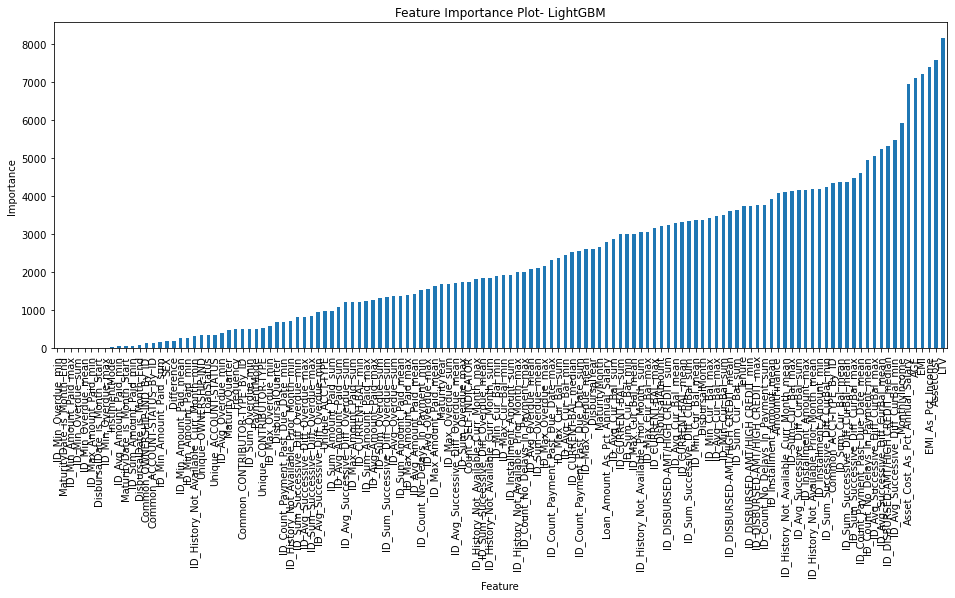

In [229]:
# plotting Feature Importance
plt.figure(figsize=(16,6));
ser = pd.Series(clf.feature_importances_,X.columns).sort_values();
ser.plot(kind='bar');
plt.title("Feature Importance Plot- LightGBM");
plt.xlabel("Feature");
plt.ylabel("Importance");

In [230]:
Submission['Top-up Month_1'] = final_preds[0]
Submission['Top-up Month_2'] = final_preds[1]
Submission['Top-up Month_3'] = final_preds[2]
Submission['Top-up Month_4'] = final_preds[3]
Submission['Top-up Month_5'] = final_preds[4]

top_up_month = ['Top-up Month_{}'.format(i) for i in range(1, 6)]
ser = Submission[top_up_month].mode(axis=1, dropna=False)[0]

Submission['Top-up Month'] = ser
Submission.drop(['Top-up Month_1','Top-up Month_2','Top-up Month_3','Top-up Month_4','Top-up Month_5'],axis=1,inplace=True)

Submission['Top-up Month'].replace({0:"12-18 Months",1:"18-24 Months",2:"24-30 Months",3:"30-36 Months",4:"36-48 Months",5:" > 48 Months",6:"No Top-up Service"},inplace=True)
Submission.to_csv("Solution_25.csv",index=None)
Submission['Top-up Month'].value_counts()

No Top-up Service    13254
 > 48 Months           969
36-48 Months           200
24-30 Months           137
30-36 Months            94
18-24 Months            74
12-18 Months            17
Name: Top-up Month, dtype: int64